In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("dataset/power_dataset.csv", sep=";")

In [3]:
df.shape

(14592, 5)

In [4]:
df.head()

,Timestamp,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
0,2019-01-01 00:15:00,"0,00","0,00","14,43","145991,80"
1,2019-01-01 00:30:00,"0,00","0,00","14,35","145991,80"
2,2019-01-01 00:45:00,"0,00","0,00","14,66","145991,80"
3,2019-01-01 01:00:00,"0,00","0,00","14,54","145991,80"
4,2019-01-01 01:15:00,"0,00","0,00","13,79","145991,80"


In [5]:
df[df.columns[1:]] = df[df.columns[1:]].apply(lambda x : [str(i).replace(",",".") for i in x ]) # change everything apart from the first column
df[df.columns[1:]] = df[df.columns[1:]].replace("nan", np.nan)

In [6]:
df.head() # the change from , to . will make the calculations later on much easier.

,Timestamp,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
0,2019-01-01 00:15:00,0.00,0.00,14.43,145991.80
1,2019-01-01 00:30:00,0.00,0.00,14.35,145991.80
2,2019-01-01 00:45:00,0.00,0.00,14.66,145991.80
3,2019-01-01 01:00:00,0.00,0.00,14.54,145991.80
4,2019-01-01 01:15:00,0.00,0.00,13.79,145991.80


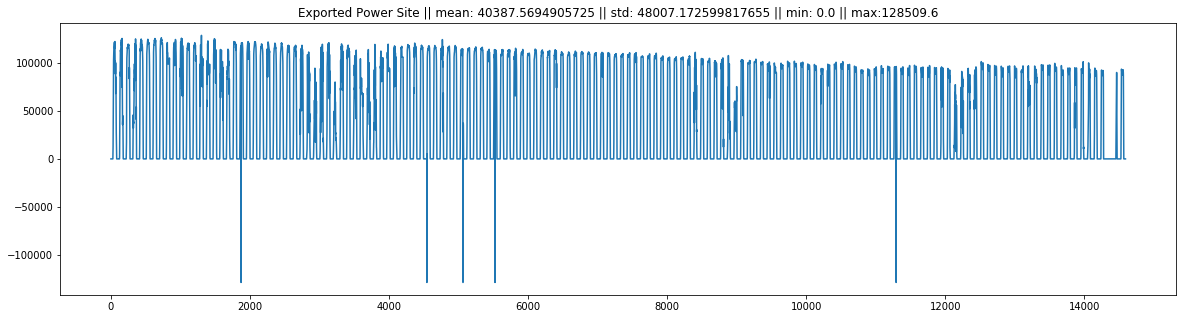

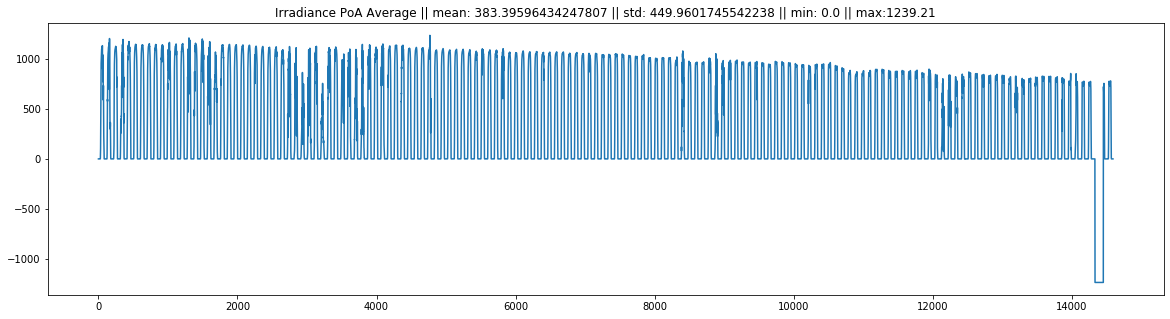

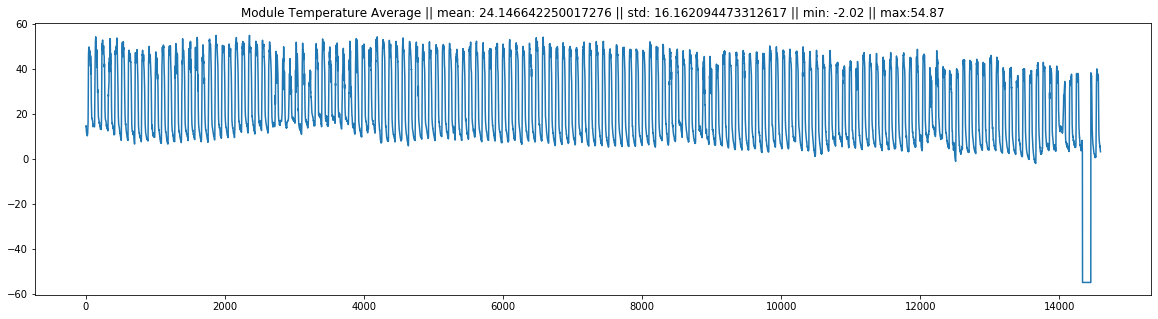

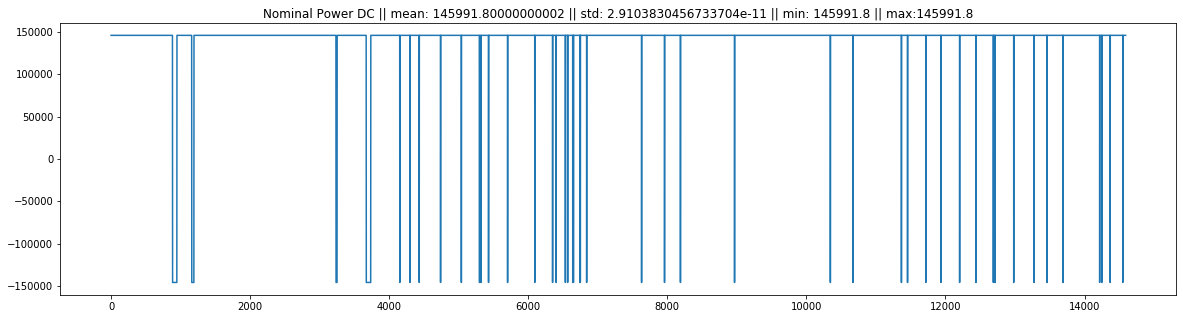

In [7]:
cols = df.columns[1:]
twin_df = df.copy()
twin_df[cols] = twin_df[cols].astype(float)
df_info = {i:"" for i in cols}
for i in cols:
    std = np.std(df[i].astype(float))  # i don't use twin_df here in order not to mess with the calculations
    mn = np.mean(df[i].astype(float))
    minimum = np.min(df[i].astype(float))
    maximum = np.max(df[i].astype(float))
    text = "|| mean: {} || std: {} || min: {} || max:{}".format(mn, std, minimum, maximum)
    
    nan_indicating_value = - np.max(np.abs(df[i].astype(float)))
    
    twin_df[i] = twin_df[i].fillna(nan_indicating_value)
    df_info[i] = {"mean":mn, "std":std, "min":minimum, "max":maximum}
    plt.figure(figsize=(20,5))
    plt.title(i+" "+text)
    plt.plot(twin_df[i]) # in order to check the actual values that would be nan otherwise.
    plt.show()

In [8]:
df_info

{'Exported Power Site': {'mean': 40387.5694905725,
  'std': 48007.172599817655,
  'min': 0.0,
  'max': 128509.6},
 'Irradiance PoA Average': {'mean': 383.39596434247807,
  'std': 449.9601745542238,
  'min': 0.0,
  'max': 1239.21},
 'Module Temperature Average': {'mean': 24.146642250017276,
  'std': 16.162094473312617,
  'min': -2.02,
  'max': 54.87},
 'Nominal Power DC': {'mean': 145991.80000000002,
  'std': 2.9103830456733704e-11,
  'min': 145991.8,
  'max': 145991.8}}

Since we have real values i replaced the occurences of the NaNs with - max value of each collumn (in order to be obvious in the plots above)

Just by noticing the plots it is straightforward to see that Irradiance and temperature average are highly correlated
(it makes sense since they are both affected by the same variable. 

second step is to normalize the collumns before feeding it in the the timeseries predictor, since the values of the features are highly vary towards each other

Also obvious from the plots that apart from the nan values there aren't any outliers in our dataset

In [9]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.index = df['Timestamp']
del df["Timestamp"]
df = df.astype(float)
df = df.resample('2700s').mean() #select timeslot. for now i select 2700sec aka 45 min
df.head()

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
Timestamp,,,,
2019-01-01 00:00:00,0.0,0.0,14.390000,145991.8
2019-01-01 00:45:00,0.0,0.0,14.330000,145991.8
2019-01-01 01:30:00,0.0,0.0,12.456667,145991.8
2019-01-01 02:15:00,0.0,0.0,11.563333,145991.8
2019-01-01 03:00:00,0.0,0.0,11.336667,145991.8


In [10]:
df[df["Exported Power Site"].isnull()]

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
Timestamp,,,,


There are several ways to tackle the Nan issue 

1. Either via interpolation or by taking the mean value of its neighbors (since we have very few nan samples compared to our actual dataset)
2. Eliminate the rows that contain these values since they don't provide actual information about our dataset

In [11]:
null_indices = list(df[df["Exported Power Site"].isnull()].index)

around_indices = []

for i in null_indices:
    around_indices.append(i-1)
    around_indices.append(i+1)

null_indices = list(set(null_indices).union(set(around_indices)))


In [12]:
null_indices.sort()

In [13]:
df.loc[null_indices]

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
Timestamp,,,,


In [14]:
cleared_df = df[~df["Exported Power Site"].isnull()]

In [15]:
from xgboost import XGBRFRegressor

In [16]:
from sklearn.metrics import r2_score


In [17]:
df["Nominal Power DC"].unique() # this feature seems that it cannot actually offer new information 

array([145991.8,      nan])

In [18]:
len(df[df["Nominal Power DC"].isnull()])/len(df["Nominal Power DC"])

0.011921891058581706

the previous ratio is the the ratio of nans vs all the data contained in the collumn.
So this collumn has absolutely no statistical importance

In [19]:
df[df["Nominal Power DC"].isnull()]

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
Timestamp,,,,
2019-01-10 05:15:00,0.000000,0.000000,8.550000,NaN
2019-01-10 06:00:00,0.000000,0.000000,8.340000,NaN
2019-01-10 06:45:00,0.000000,3.226667,8.036667,NaN
2019-01-10 07:30:00,15548.916667,167.350000,10.793333,NaN
2019-01-10 08:15:00,66146.066667,606.110000,26.593333,NaN
2019-01-10 09:00:00,107995.146667,895.473333,39.426667,NaN
2019-01-10 09:45:00,113943.290000,993.493333,44.906667,NaN
2019-01-10 10:30:00,118623.650000,1074.233333,48.436667,NaN
2019-01-10 11:15:00,118581.266667,1112.660000,49.100000,NaN


"Nominal Power DC" has no statistical significance especially since it's either a constant or a nan value.

amongst these features we could've added the feature of season aka winter, summer..

In [20]:
(df[df["Module Temperature Average"].isnull()]["Exported Power Site"]).unique()  # whic means that when we have nan values 
# on the Module Temperature Average the site doesn't produce energy at all.

array([0.])

In [21]:
f_cols = list(set(df.columns) - set(["Nominal Power DC"]))
print(f_cols)
final_df = df[f_cols]

['Exported Power Site', 'Irradiance PoA Average', 'Module Temperature Average']


In [22]:
final_df.head()

,Exported Power Site,Irradiance PoA Average,Module Temperature Average
Timestamp,,,
2019-01-01 00:00:00,0.0,0.0,14.390000
2019-01-01 00:45:00,0.0,0.0,14.330000
2019-01-01 01:30:00,0.0,0.0,12.456667
2019-01-01 02:15:00,0.0,0.0,11.563333
2019-01-01 03:00:00,0.0,0.0,11.336667


In [23]:
final_df.tail()

,Exported Power Site,Irradiance PoA Average,Module Temperature Average
Timestamp,,,
2019-06-01 21:00:00,0.0,0.0,5.886667
2019-06-01 21:45:00,0.0,0.0,5.636667
2019-06-01 22:30:00,0.0,0.0,4.540000
2019-06-01 23:15:00,0.0,0.0,3.670000
2019-06-02 00:00:00,0.0,0.0,3.180000


/home/dimitrisl/miniconda3/envs/timeseries/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


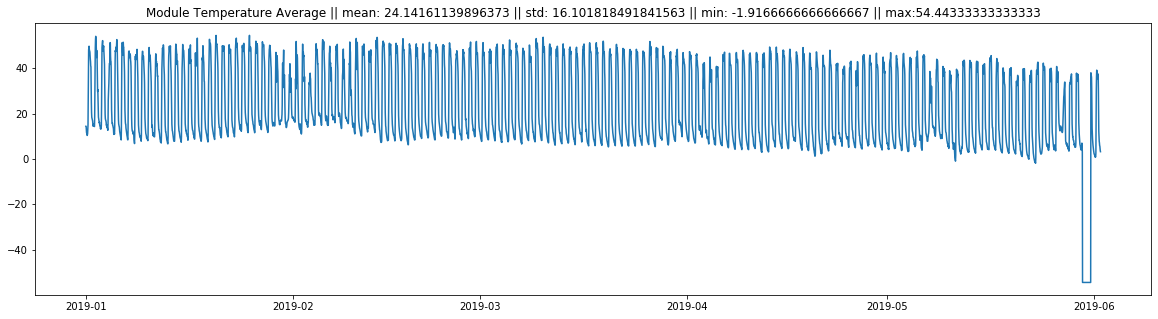

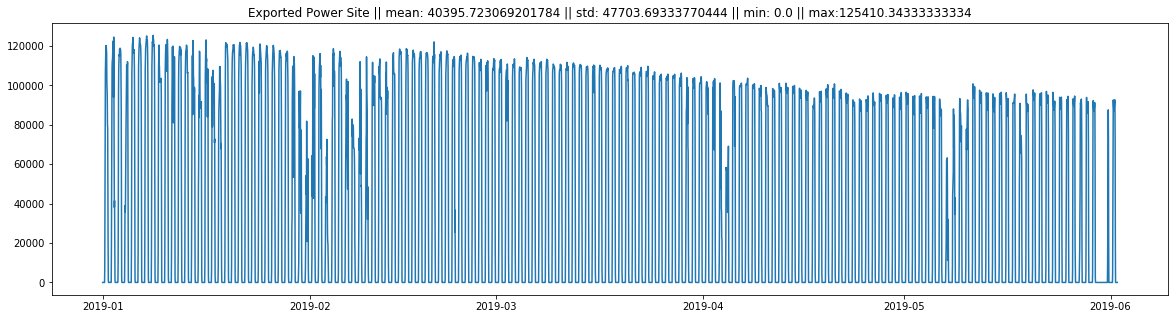

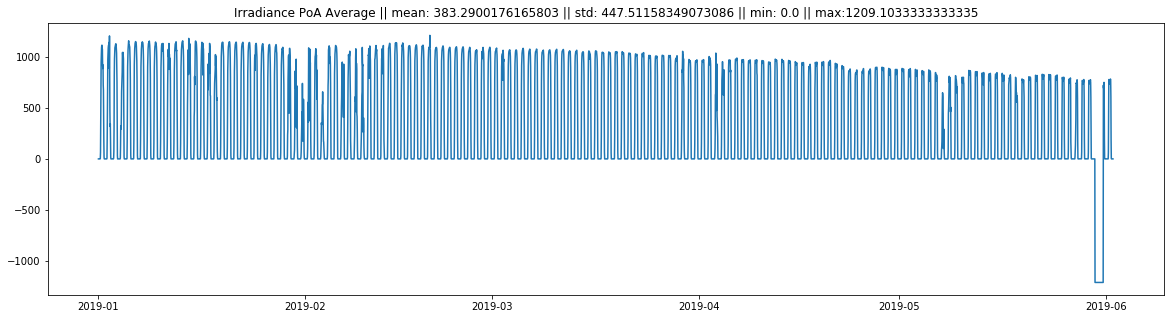

In [24]:
for i in ['Module Temperature Average', 'Exported Power Site', 'Irradiance PoA Average']:
    std = np.std(final_df[i].astype(float))  # i don't use twin_df here in order not to mess with the calculations
    mn = np.mean(final_df[i].astype(float))
    minimum = np.min(final_df[i].astype(float))
    maximum = np.max(final_df[i].astype(float))
    text = "|| mean: {} || std: {} || min: {} || max:{}".format(mn, std, minimum, maximum)
    
    nan_indicating_value = - np.max(np.abs(df[i].astype(float)))
    
    df_info[i] = {"mean":mn, "std":std, "min":minimum, "max":maximum}
    plt.figure(figsize=(20,5))
    plt.title(i+" "+text)
    plt.plot(final_df[i].fillna(nan_indicating_value).astype(float)) # in order to check the actual values that would be nan otherwise.
    plt.show()

In [25]:
final_df[final_df["Exported Power Site"].isnull()]

,Exported Power Site,Irradiance PoA Average,Module Temperature Average
Timestamp,,,


changing the nan value of exported Power Site to 0 should be correct since this value has to be a positive integer

In [26]:
i = "Exported Power Site"
final_df[i] = final_df[i].fillna(0)

/home/dimitrisl/miniconda3/envs/timeseries/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
final_df = final_df.dropna() # actually drop the nan values since we can't make an inference out of them

In [28]:
final_df.isnull().any()

Exported Power Site           False
Irradiance PoA Average        False
Module Temperature Average    False
dtype: bool

In [29]:
# at this point we have to create the buckets of the ranges

In [30]:
final_df[['Module Temperature Average', 'Exported Power Site', 'Irradiance PoA Average']] = final_df[['Module Temperature Average', 'Exported Power Site', 'Irradiance PoA Average']].astype(float)

In [31]:
final_df.head()

,Exported Power Site,Irradiance PoA Average,Module Temperature Average
Timestamp,,,
2019-01-01 00:00:00,0.0,0.0,14.390000
2019-01-01 00:45:00,0.0,0.0,14.330000
2019-01-01 01:30:00,0.0,0.0,12.456667
2019-01-01 02:15:00,0.0,0.0,11.563333
2019-01-01 03:00:00,0.0,0.0,11.336667


In order to make use of time window we will use the hyper parameter set_time_range as the condition to group up timestamps
and take the average the row values

In [32]:
from sklearn.model_selection import train_test_split

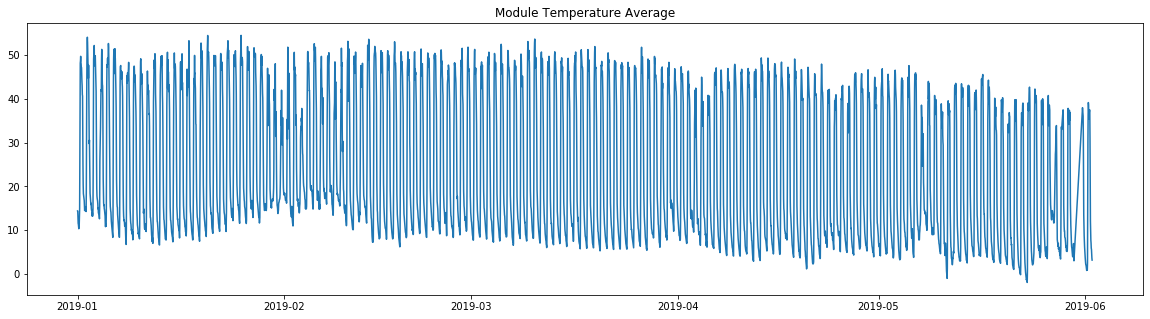

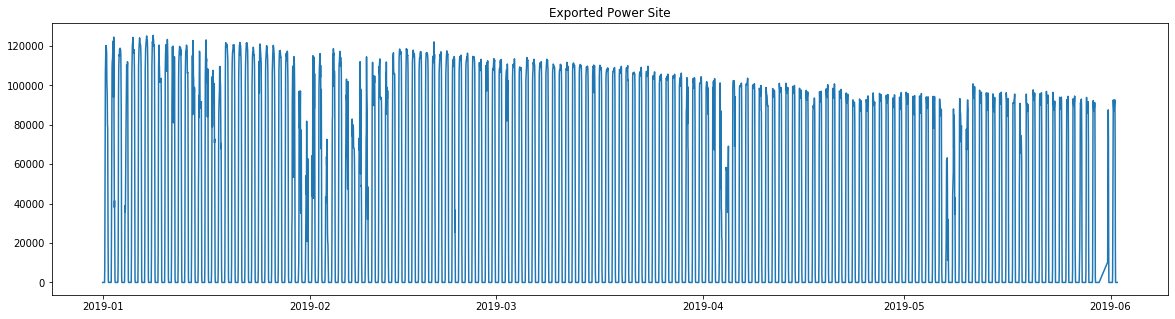

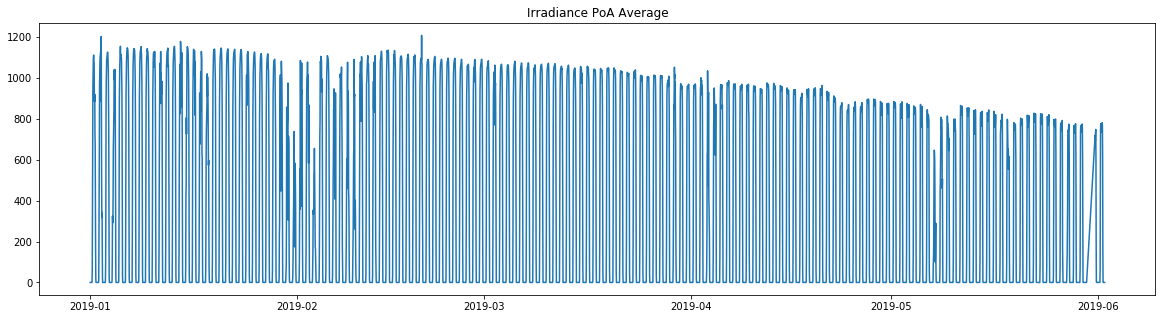

In [33]:
for i in ['Module Temperature Average', 'Exported Power Site', 'Irradiance PoA Average']:
    plt.figure(figsize=(20,5))
    plt.title(i)
    plt.plot(final_df[i]) # in order to check the actual values that would be nan otherwise.
    plt.show()

In [34]:
split_index = (7 * final_df.shape[0])//10 # i am going to split the dataset 70% train 30% test

In [35]:
print(final_df.index.to_list()[split_index])
label = "Exported Power Site"

2019-04-16 12:45:00


In [36]:
def clear_sets(X_all, label):
    Y_series_train = X_all[label]
    del X_all[label]
    X_series_train = X_all
    return X_series_train, Y_series_train

In [37]:
series_train = final_df.loc[final_df.index <= final_df.index.to_list()[split_index]].copy()
X_series_train, Y_series_train = clear_sets(series_train, label)

In [38]:
series_test = final_df.loc[final_df.index > final_df.index.to_list()[split_index]].copy()
X_series_test, Y_series_test = clear_sets(series_test, label)

In [39]:
[i.shape for i in (X_series_train, X_series_test)]

[(3378, 2), (1447, 2)]

In [41]:
[i.shape for i in (Y_series_train, Y_series_test)]

[(3378,), (1447,)]

In [44]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000)


In [49]:
reg.fit(X_series_train, Y_series_train,
        eval_set=[(X_series_train, Y_series_train), (X_series_test, Y_series_test)],
        early_stopping_rounds=50,
       verbose=False)

[15:03:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/dimitrisl/miniconda3/envs/timeseries/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dimitrisl/miniconda3/envs/timeseries/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

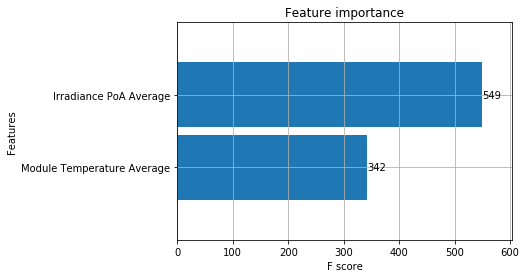

In [52]:
from xgboost import plot_importance

_ = plot_importance(reg, height=0.9)


In [73]:
y_test_predictions = reg.predict(X_series_test)
y_train_predictions = reg.predict(X_series_train)

0.9901582726701621 test


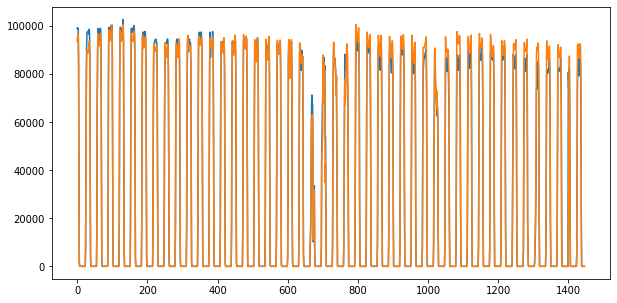

0.9934520714894305 train


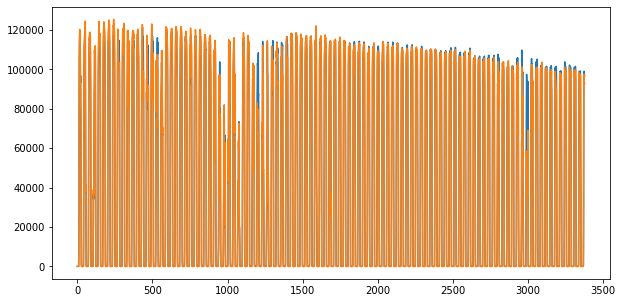

In [76]:
print(r2_score(predictions, Y_series_test.values),"test")
plt.figure(figsize=(10,5))
plt.plot(y_test_predictions)
plt.plot(Y_series_test.values)
plt.show()

print(r2_score(y_train_predictions, Y_series_train.values),"train")
plt.figure(figsize=(10,5))
plt.plot(y_train_predictions)
plt.plot(Y_series_train.values)
plt.show()